<a href="https://colab.research.google.com/github/jupastro/ECG_analysis/blob/main/Ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading files**
First of all, we download the .zip file onto our session

In [ ]:
! wget https://physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [1]:
import numpy as np 
import pandas as pd
from pandas_profiling import ProfileReport

In [ ]:
!unzip /content/ptb-diagnostic-ecg-database-1.0.0.zip

We check the content stored in the header files

In [ ]:
with open('/content/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re.hea',encoding='latin-1') as f:
    for line in f:
        print(line)

The .hea files contain information about the content and the reading of the other files as well as several fields related to patient treatment and diagnosis.

In order to fully characterize each patient we need to completely retrieve those fields. So we extract them based in the structure of the first .hea file. 

In [3]:
import pandas as pd
import os
def create_dataset(path,patient):
  '''Inputs:
path(str): path in which the file of interest is stored
patient(str): name of the patient to use as an identifier for the df i.e Patient001
'''

 
  columns=[]
  data=[]
  columns.append('Patient')
  data.append(patient)
  with open(path) as f:
   for line in f:
        if line.startswith('#'):
          #Appending to the columns list the content starting with a #, which represent column names such as # Dosage --> ['Dosage']
          columns.append(line.split(':')[0].replace('#',''))
          # Then as we split the each line by the ':' we take the first part of the sentence and remove it from the line and also remove the \n
          data.append(line.replace(line.split(':')[0]+':','').replace('\n',''))
          #print(f'Column {line.split(':')[0]} and data extracted {line.split(':')[1:]}')

  return pd.DataFrame([data],columns=columns)

def load_all_files(parent):
  '''
  Inputs:
    parent(str): directory in which the files of interest are stored
  '''
  pacientes=[]
  patients_folders=os.listdir(parent)
  for i in patients_folders:
    
   
    files=[]
   
    try:
      for ii in os.listdir(parent+'/'+i):
        if ii.endswith('.hea'):
          
          try:
             files.append(create_dataset(parent+'/'+i+'/'+ii,i))
          except Exception as E:print(E)
      if len(files)!=0:pacientes.append(pd.concat(files))
      #files=[create_dataset(parent+'/'+i+'/'+ii,i) for ii in os.listdir(parent+'/'+i) if i.endswith('.hea')]
    except Exception as E:print(E) 
      
    
  return pd.concat(pacientes)
  

In [4]:
def convert_datetime(df,date_codes,infer_format=True):
    '''
    Inputs:
      df(pd.DataFrame): DataFrame to be analyzed to coerce the columns that contain dates to datetime formats.
      date_codes(list): list that contains the string names of the columns to check if they are datetimes i.e ['Dates','date', 'time']
    
    '''
    try:
        for i in df.columns:
            if any([x.lower() in i.lower() for x in date_codes]):
                print(f'Trying to coerce {i} as datetime format')
                try:
                  df[i]=pd.to_datetime(df[i],errors='coerce',infer_datetime_format=infer_format)
                
                  print(f' {i} was converted to a Datetime')
                except Exception as E:
                  print(E)
    except: print('DateCodes must be a list of strings')
    return df

def drop_constant(df):
    for i in df.columns:
        if len(df[i].dropna().unique())==1:
            df=df.drop(columns=[i])
            print(f' {i} was removed from the df as it presented a constant value')
    return df
    
def convert_categorical(df,column):
    df[column] = df[column].astype("category")
    return df

def check_dtypes(input,threshold):
    '''
    Inputs:
      Allows to adapt automatically a dataFrame from object columns to categorical and numerical 
        input(pd.DataFrame): df que quiere ser adaptado
        threshold(int): n de columnas para optar por categorica o numérica

    '''
    
    for i in input.columns:
        if input[i].dtype=='object':
            if len(input[i].unique())<threshold:
                print(f'Variable {i} was coerced to categorical')
                input=convert_categorical(input,i)
            else:
                input=input.replace(',','.')
                try:
                    input[i] = pd.to_numeric(input[i], downcast="float")
                    print(f'Variable {i} was coerced to numeric')
                except Exception as E:
                    print(E)
                    print(f'There was a problem converting {i}')
    return input

      
                    

## Creating initial database


In [5]:
db=load_all_files('/content/ptb-diagnostic-ecg-database-1.0.0')

[Errno 20] Not a directory: '/content/ptb-diagnostic-ecg-database-1.0.0/RECORDS'
[Errno 20] Not a directory: '/content/ptb-diagnostic-ecg-database-1.0.0/ptb.png'
[Errno 20] Not a directory: '/content/ptb-diagnostic-ecg-database-1.0.0/CONTROLS'
[Errno 20] Not a directory: '/content/ptb-diagnostic-ecg-database-1.0.0/README'
[Errno 20] Not a directory: '/content/ptb-diagnostic-ecg-database-1.0.0/SHA256SUMS.txt'


We check for the header to see whether it has been correctly created or not

In [6]:
db.head()

Patient  age    sex     ECG date  Diagnose    Reason for admission  \
0  patient122   68   male   21/07/1992                   Healthy control   
0  patient206   32   male   05/03/1996               Bundle branch block   
0  patient065   52   male   18/09/1991             Myocardial infarction   
0  patient065   52   male   20/09/1991             Myocardial infarction   
0  patient065   52   male   25/03/1992             Myocardial infarction   

   Acute infarction (localization)  Former infarction (localization)  \
0                               no                                no   
0                               no                                no   
0           infero-postero-lateral                                no   
0           infero-postero-lateral                                no   
0           infero-postero-lateral                                no   

   Additional diagnoses    Smoker  ...  Infarction date  Catheterization date  \
0                    no   unknown  ...              n/a                   n/a   
0              Tinnitus        no  ...              n/a                   n/a   
0                    no        no  ...        13-Sep-91             23-Sep-91   
0                    no        no  ...        13-Sep-91             23-Sep-91   
0                    no        no  ...        13-Sep-91             23-Sep-91   

   Admission date  Medication pre admission  Start lysis therapy (hh.mm)  \
0             n/a                       n/a                          n/a   
0             n/a                       n/a                          n/a   
0       13-Sep-91                         -                        08:45   
0       13-Sep-91                         -                        08:45   
0       13-Sep-91                         -                        08:45   

   Lytic agent  Dosage (lytic agent)  \
0          n/a                   n/a   
0          n/a                   n/a   
0    Gamma-TPA                100 mg   
0    Gamma-TPA                100 mg   
0    Gamma-TPA                100 mg   

                              Additional medication  In hospital medication  \
0                                               n/a                     n/a   
0                                               n/a                     n/a   
0   ASA Metoprolol Isosorbit-Mononitrate Molsidomin                     ASA   
0   ASA Metoprolol Isosorbit-Mononitrate Molsidomin                     ASA   
0   ASA Metoprolol Isosorbit-Mononitrate Molsidomin                     ASA   

   Medication after discharge  
0                         n/a  
0                         n/a  
0              ASA ACE-Hemmer  
0              ASA ACE-Hemmer  
0              ASA ACE-Hemmer  

[5 rows x 49 columns]

As we can observe some of the columns contain dates and haven't been correctly retrieved so we must convert them. 

In [7]:

#Convert datetimes
catetherization_date=db[' Catheterization date']
db.drop(columns=' Catheterization date',inplace=True)
db['Catetherization date']=catetherization_date.iloc[:,0]
db=convert_datetime(db,date_codes=['date','Dates'],infer_format=True)
#Catheterization dates appears twice



Trying to coerce  ECG date as datetime format
  ECG date was converted to a Datetime
Trying to coerce  Infarction date (acute) as datetime format
  Infarction date (acute) was converted to a Datetime
Trying to coerce  Previous infarction (1) date as datetime format
  Previous infarction (1) date was converted to a Datetime
Trying to coerce  Previous infarction (2) date as datetime format
  Previous infarction (2) date was converted to a Datetime
Trying to coerce  Infarction date as datetime format
  Infarction date was converted to a Datetime
Trying to coerce  Admission date as datetime format
  Admission date was converted to a Datetime
Trying to coerce Catetherization date as datetime format
 Catetherization date was converted to a Datetime


In [8]:
import numpy as np
#replacing unknowns and n/a as nans although sometimes 
#we have n/a that means that no treatment/therapy has been performed
db.replace(' unknown',np.nan,inplace=True)
db.replace(' n/a',np.nan,inplace=True)

In [9]:
db=check_dtypes(db,threshold=40)

Unable to parse string "patient122" at position 0
There was a problem converting Patient
Variable  age was coerced to numeric
Variable  sex was coerced to categorical
Variable  Diagnose was coerced to categorical
Variable  Reason for admission was coerced to categorical
Variable  Acute infarction (localization) was coerced to categorical
Variable  Former infarction (localization) was coerced to categorical
Unable to parse string " no" at position 0
There was a problem converting  Additional diagnoses
Variable  Smoker was coerced to categorical
Variable  Number of coronary vessels involved was coerced to categorical
Variable  Hemodynamics was coerced to categorical
Unable to parse string " Akinesia infero-postero-lateral wall" at position 2
There was a problem converting  Ventriculography
Variable  Chest X-ray was coerced to categorical
Unable to parse string "  110/70 mmHg" at position 2
There was a problem converting  Peripheral blood Pressure (syst/diast)
Unable to parse string "   2

## Profile Report

In [10]:
profile = ProfileReport(db, title="ECG Database", html={"style":{"full_width":True}})

In [11]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Installing the wfdb**

In [12]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 5.3 MB/s 


In [13]:
# import the WFDB package

import matplotlib.pyplot as plt
import wfdb
from wfdb import processing
record_path='/content/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re'


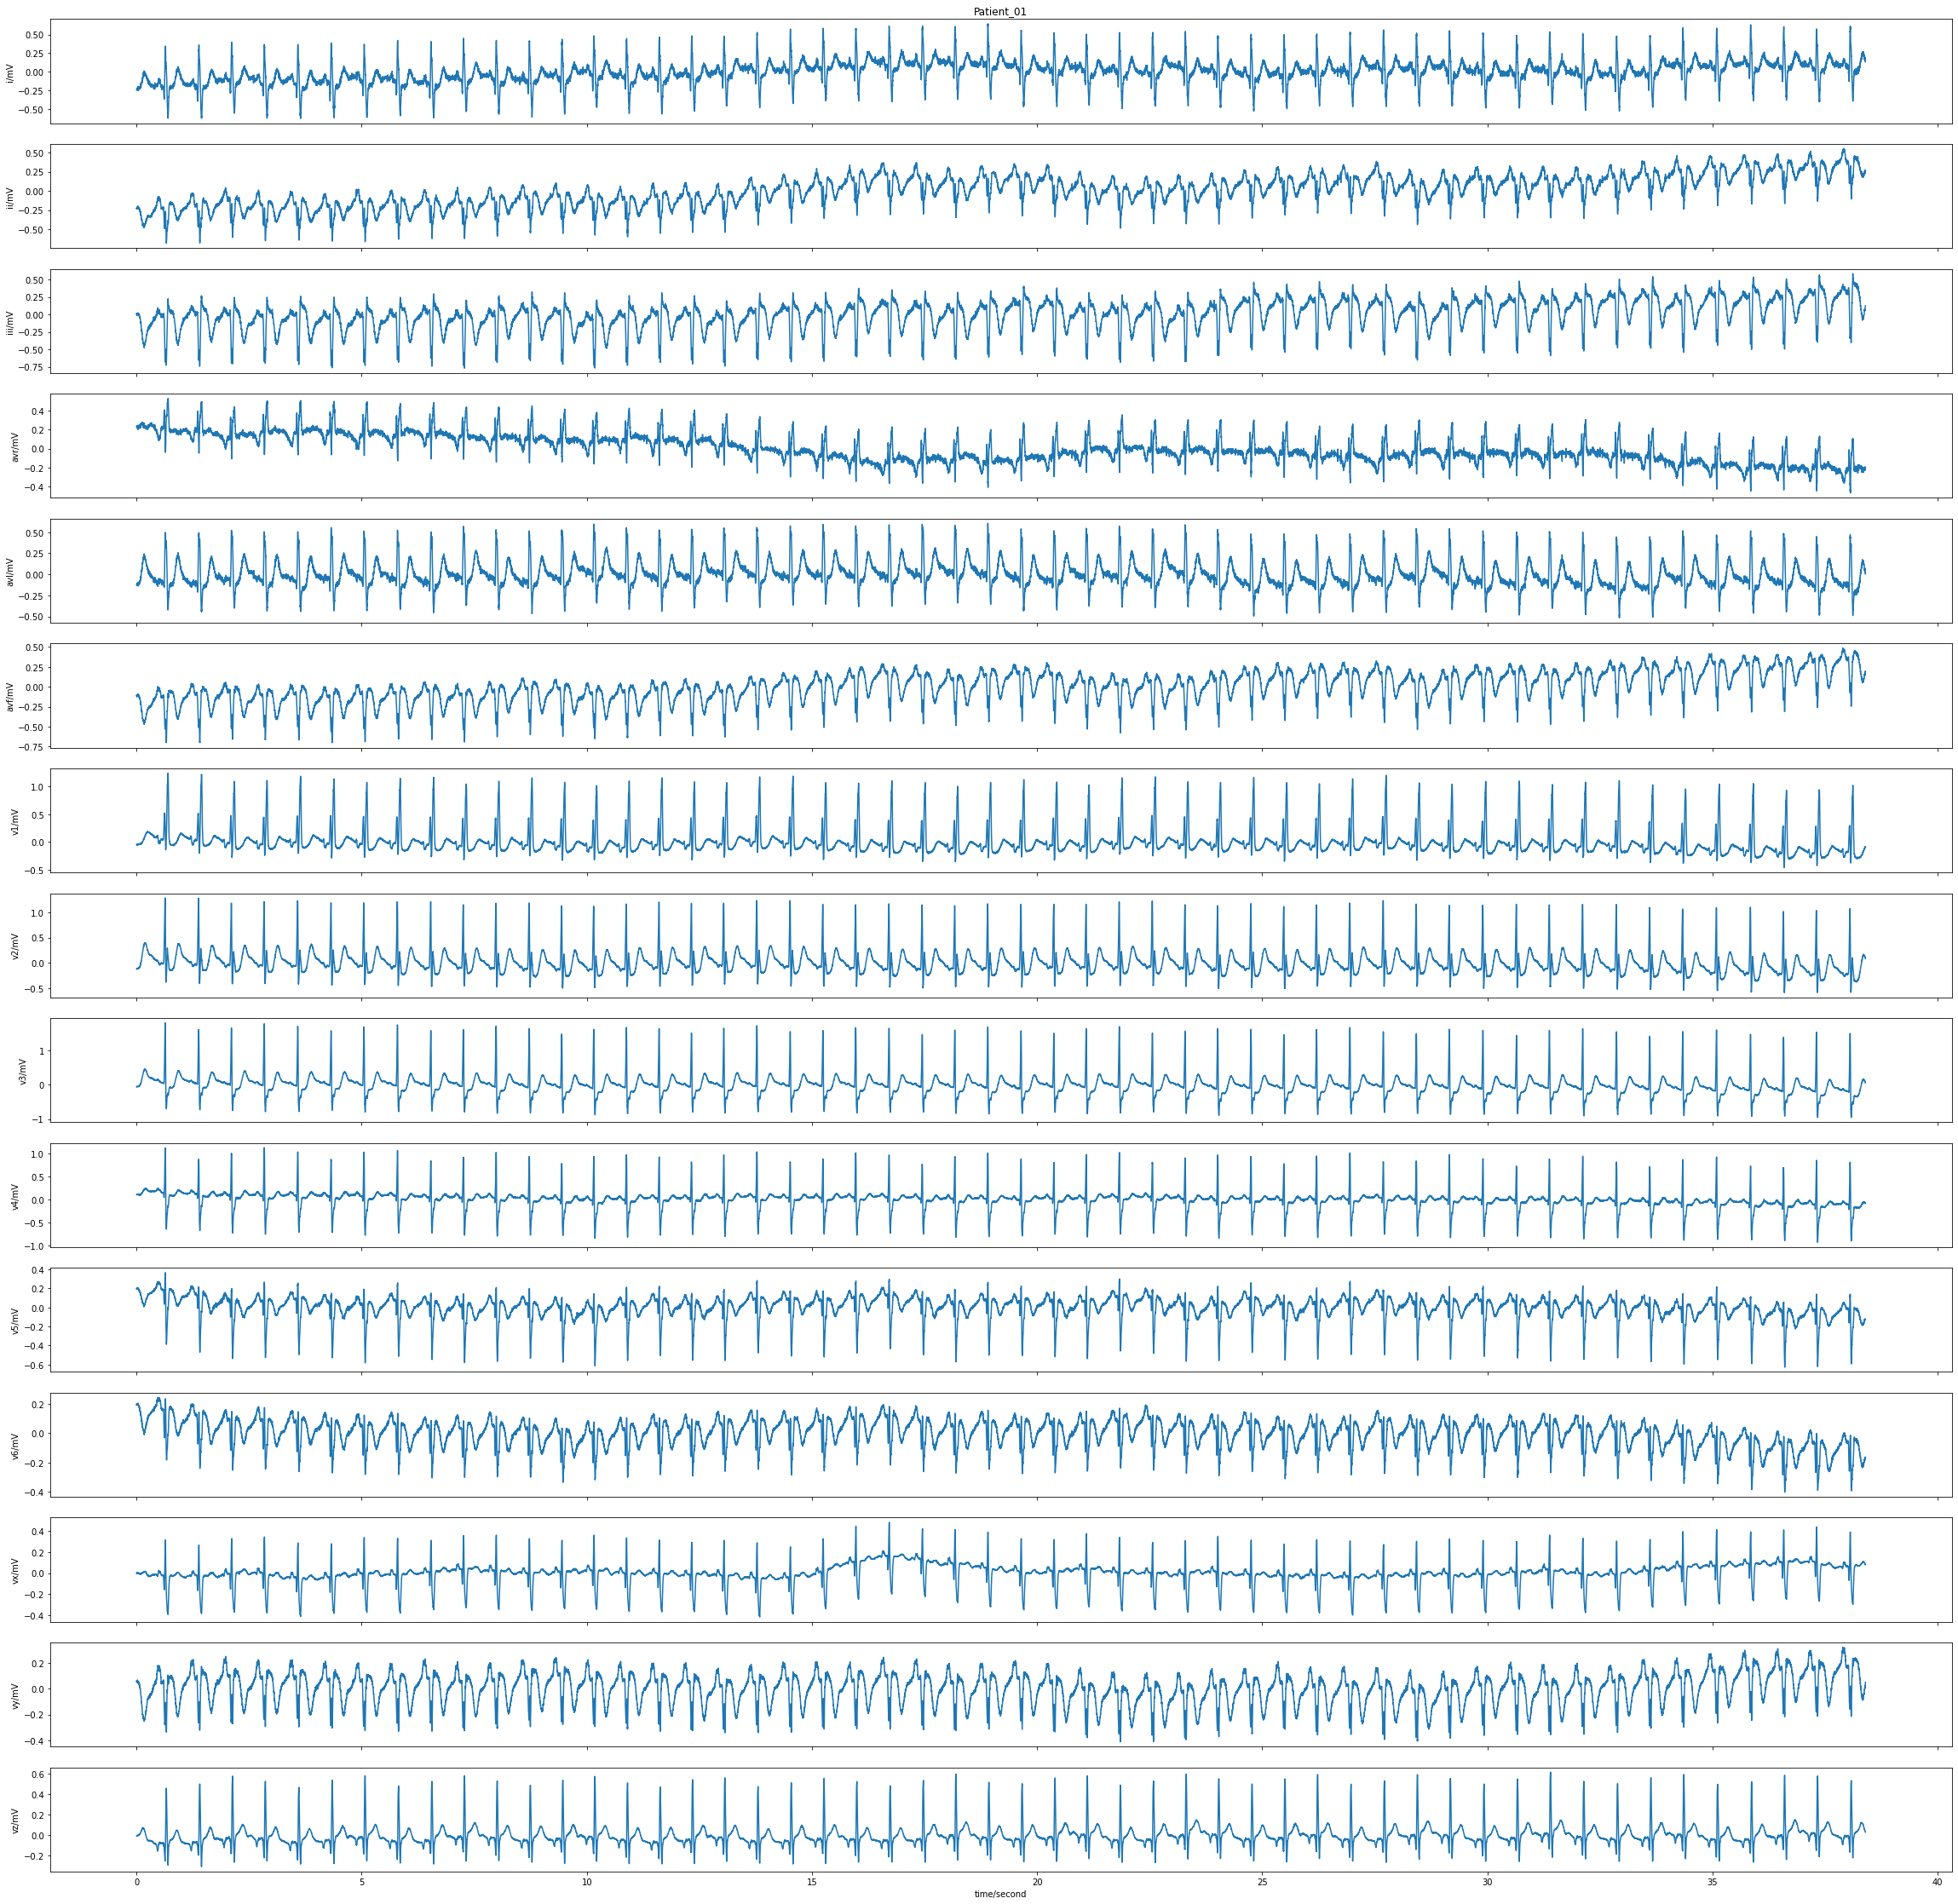

In [87]:
def visualize_recordings(path, title,N,save=False):
  #load the record
  record = wfdb.rdrecord(path)

  # plot the record to screen
  fig=wfdb.plot_wfdb(record=record, title=title,figsize=(40,40),return_fig=True,)
  if save:#saving the plotted file
    fig.savefig('Recording_'+title+'.png')

visualize_recordings(record_path,'Patient_01',N,save=True)


In [31]:

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()




In [17]:
os.chdir('/content/ptb-diagnostic-ecg-database-1.0.0/patient001/')

In [18]:
file='s0010_re'

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


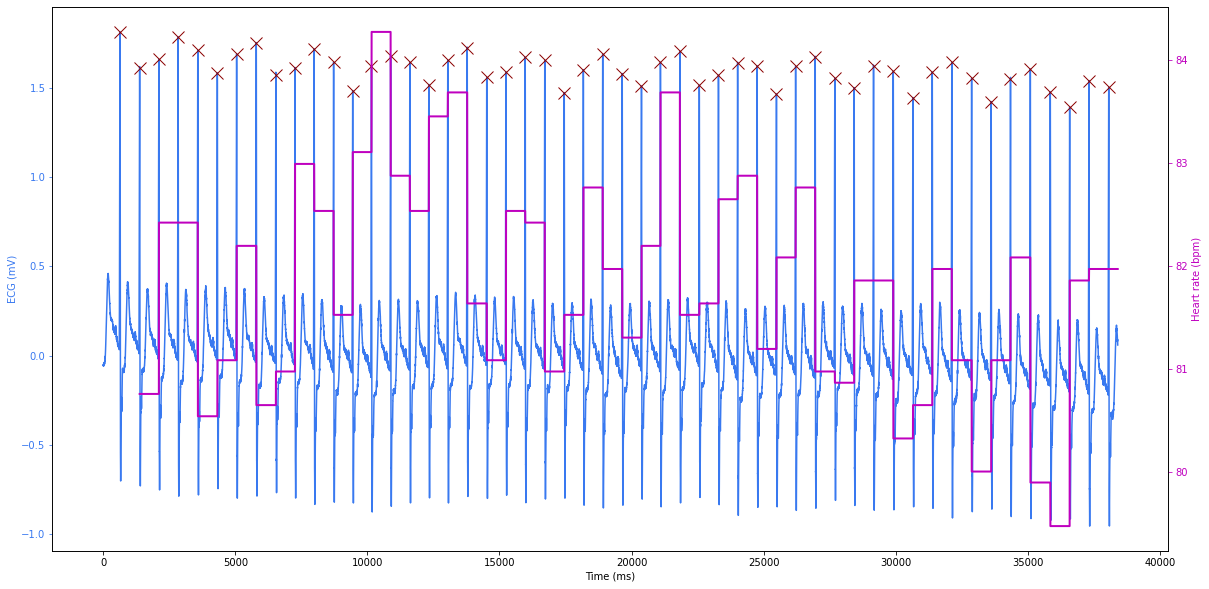

In [32]:

import wfdb
from wfdb import processing
sig, fields = wfdb.rdsamp(file, channels=[8])
# Run QRS detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
peaks_hr(sig=sig[:,0], peak_inds=sorted(xqrs.qrs_inds), fs=fields['fs'],
         title="")

In [20]:
beats_record=len(xqrs.qrs_inds)
avg_hr_min=beats_record*fields['fs']/len(sig[:,0])*60
avg_hr_min

81.25

# Pan Tompkins implementation to detect QRS

In order to detect a QRS complex not only with the default functions included in the wfdb but also applying the common Pan-Tompkins algorithm I've implemented it using:
1. Bandpass filter to remove the low freqs noise(such as the baseline noise) and the high freqs noise such as the power-line noise.
2. Derivative filter to smooth the signal 
3. Square the signal to better detect QRS peaks 
4. Integration by means of a sliding mean



## Band-pass filter

In [21]:
import scipy.signal as signal
import seaborn as sns


In [88]:
def bandpass_filter(fs,f1,f2):
    b=signal.firwin(20, [f1*2/fs, f2*2/fs], pass_zero=False)
    w,h=signal.freqz(b)
    # plt.plot(fs*w/np.pi,np.abs(h),'r')
    # plt.axis([0.1,fs/2,-1,5])
    # plt.xlabel("Frequency [Hz]")
    # plt.ylabel("Amplitude")
    # plt.title("BandPass Module")
    # plt.grid()
    # plt.show()
        
    return b

def filtering(filter,sig,a=[1.]):
    output=signal.filtfilt(filter, a, sig)
    return output

def Pan_Tompkins_RR(record_path,patient,bandpass=[5,30],fs=1000,plot=False,poincare_plot=False,plot_steps=False,detect_SQ=False,save_annotations=True):
  '''
  Inputs:
  record_path(str): string with the filename with no extension
  bandpass(list):list including two values to be used as the cutoff frequencies of the bandpass filter
  plot(boolean): boolean indicating whether to plot a 10% of the signal with the RR and QRS complex detected
  poincare_plot(boolean): boolean indicating whether to plot a poincare plot showing the regularity of HRV
  plot_steps(boolean):boolean indicating whether to plot all the steps performed to the signal for the detection of the RR complexes
  detect_SQ(boolean):boolean indicating whether to search of not for the
  Outputs:
  df(pd.DataFrame) with the extracted measurements
  R markers
  '''
 
  #Creating a bandpass filter to remove undesired noise from the signal i.e baseline noise(low freq)/electrical power-line noise(50hz/60hz)
  sig, fields = wfdb.rdsamp(record_path, channels=[8])
  sig=sig[:,0]
  b=bandpass_filter(fs,bandpass[0],bandpass[1])
  bandpass_filtered=filtering(b,sig[:])
  #Applying a derivative filter 
  h_d= [-1/8,-2/8,0,2/8,1/8]
  derivative_filtered= signal.convolve(bandpass_filtered,h_d)
  #Square root of the signal to emphasize QRS complex
  squared_signal=derivative_filtered**2
  #Integration window by using Moving-average
  N=25

  integrated_signal=[0]*len(squared_signal)
  #Mean sliding window
  for n in range(N-1,len(squared_signal)):
      for i in range(N-1):
          integrated_signal[n]=integrated_signal[n]+squared_signal[n-i]
      integrated_signal[n]=integrated_signal[n]/N  
  #Peak detection
  #selection of a threshold of the 90% of the signal
  threshold= np.percentile(integrated_signal,95)
  #the peaks will be shifted to the right due to the moving average and derivative filter so we must correct them into the original signal
  peaks, _ = signal.find_peaks(integrated_signal, distance=200,height=threshold)
  #adding a  max bpm window to select the minimum time span where the peak can be placed
 
  max_bpm = 300

  search_radius = int(fs * 60 / max_bpm)
  Rmarkers=[]
  Qmarkers=[]
  Smarkers=[]
  Rcorrected_peak_inds=[]
  Qcorrected_peak_inds=[]
  Scorrected_peak_inds=[]
  
  for i in peaks:
    if (i-search_radius)<0:signal_window=bandpass_filtered[0:i+search_radius]
    else:
      if (i+search_radius)>len(sig):signal_window=bandpass_filtered[i-search_radius:]
      else:signal_window=bandpass_filtered[i-search_radius:i+search_radius]

    Rcorrected_peak_inds.append(np.max(signal_window))
   
    

    Rmarkers.append(i-search_radius+np.argmax(signal_window))
  
    if detect_SQ:
      Scorrected_peak_inds.append(np.min(signal_window))
      Qmarkers.append(i-signal.argrelextrema(np.flip(signal_window[0:-search_radius]), np.less)[0][0])
      Smarkers.append(i+np.argmin(signal_window[search_radius:]))
      Qcorrected_peak_inds.append(signal_window[(Qmarkers[-1])-i-search_radius])
      

    
    
   
  if plot_steps:
    plt.figure(figsize=(30,30))
    plt.subplot(5,1,1),plt.plot(sig[:]),plt.title('Raw signal'),plt.xlabel('Time(ms)'),plt.ylabel('Amplitude(mV)')
    plt.subplot(5,1,2),plt.plot(bandpass_filtered),plt.title('Bandpass filtered signal'),plt.xlabel('Time(ms)'),plt.ylabel('Amplitude(mV)')
    plt.subplot(5,1,3),plt.plot(derivative_filtered),plt.title('Derivative filtered signal'),plt.xlabel('Time(ms)'),plt.ylabel('Amplitude(mV)')
    plt.subplot(5,1,4),plt.plot(squared_signal),plt.title('Squared signal'),plt.xlabel('Time(ms)'),plt.ylabel(r'Amplitude(mV)^2')
    plt.subplot(5,1,5),plt.plot(integrated_signal),plt.title('Integrated signal'),plt.xlabel('Time(ms)'),plt.ylabel(r'Amplitude(mV)^2')

  
  if plot:
    plt.figure(figsize=(20,20))
    plt.title('Detected QRS complexes'),plt.xlabel('Time(ms)'),plt.ylabel('Amplitude(mV)')
    plt.plot(bandpass_filtered,label='Signal') # plotting t, a separately 
    
    plt.plot(Rmarkers,Rcorrected_peak_inds,'o',label='R') # plotting t, b separately 
    if detect_SQ:
      plt.plot(Qmarkers,Qcorrected_peak_inds,'o',label='Q') # plotting t, b separately 
      plt.plot(Smarkers,Scorrected_peak_inds,'o',label='S') # plotting t, b separately 
    plt.legend()
    plt.xlim([0,int(0.1*len(sig))])
    plt.show()
  if detect_SQ:
    QR_intervals=-np.mean(np.array(Qmarkers)-np.array(Rmarkers[0:len(Qmarkers)]))
    
    RS_intervals=np.mean(np.array(Smarkers)-np.array(Rmarkers))
    QRS_time=-np.mean(np.array(Qmarkers)-np.array(Smarkers))
  
  R_intervals=peaks[1:]-peaks[:-1]
  avg_RR_interval=np.mean(R_intervals)
  SDRR=np.std(R_intervals)
  HR=1000*60/(avg_RR_interval)
  #Now we proceed to include all the different computations
  #print(f'The Heart Rate is {HR}, the total number of Heart Beats is {len(peaks)},\nthe average RR time interval(ms) {avg_RR_interval} and the standard deviation between RR complexes {SDRR}')
  if poincare_plot:
    res = sns.kdeplot(R_intervals[:-1],R_intervals[1:],color='blue',shade=True)
    plt.plot(range(500,800),range(500,800),'cyan')
    plt.title('Poincaré plot')
    plt.xlabel('RR[n]')
    plt.ylabel('RR[n-1]')
    plt.xlim(500,800)
    plt.ylim(500,800)
    plt.show()
  
  if detect_SQ:
    
    data=[patient,HR,len(peaks),avg_RR_interval,SDRR,QR_intervals,RS_intervals,QRS_time]
    columns=['Patient','Heart Rate','Heart Beats','Average_RR_interval(ms)','SDRR','QR_interval','RS_interval','QRS_time']
  else:
    data=[patient,HR,len(peaks),avg_RR_interval,SDRR]
    columns=['Patient','Heart Rate','Heart Beats','Average_RR_interval(ms)','SDRR']
  
  return pd.DataFrame([data],columns=columns),Rmarkers, bandpass_filtered


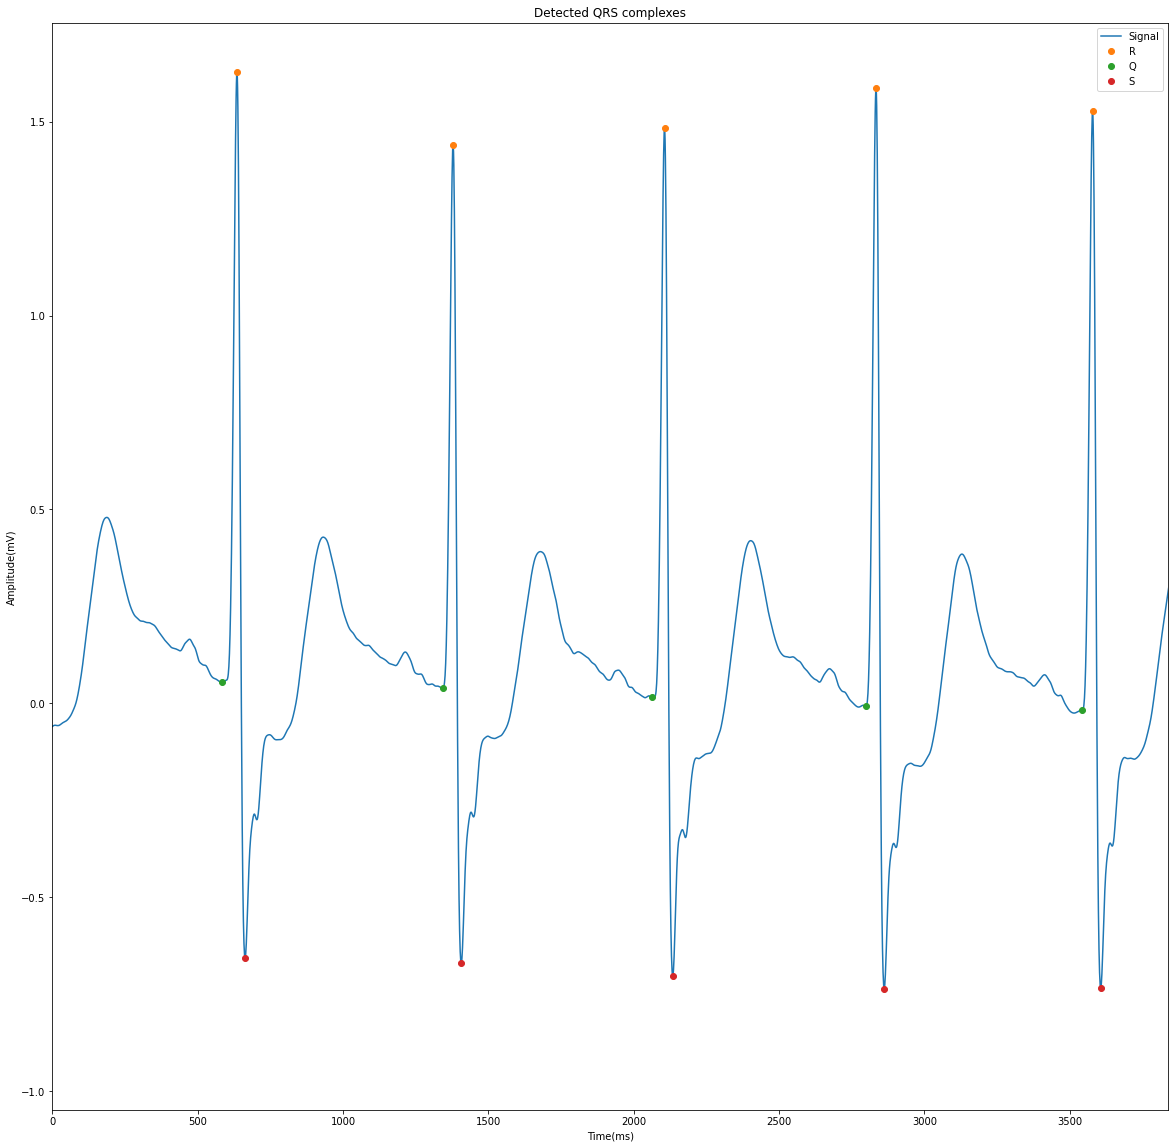

The Heart Rate is 81.77008177008177, the total number of Heart Beats is 52,
the average RR time interval(ms) 733.7647058823529 and the standard deviation between RR complexes 9.2621689648323


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


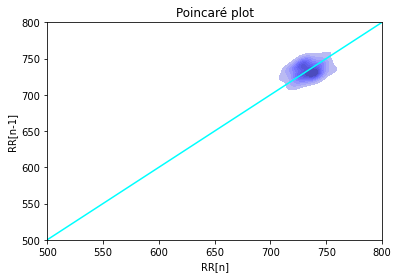

In [71]:
df,RRs,filtered_signal=Pan_Tompkins_RR(file,'Patient01',bandpass=[5,15],fs=1000,plot=True,poincare_plot=True,plot_steps=False,detect_SQ=True)

In [65]:
#In order to store an annotation into the file
wfdb.wrann(file, 'atr', np.array(RRs), symbol=['R' for i in range(0,len(RRs))])

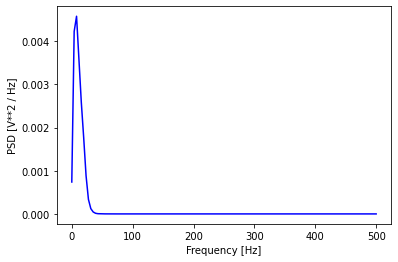

9

In [75]:
#It would also be interesting to extract some frequency features such as PSD of FFT peaks
#or wavelet 
from scipy.fftpack import fft

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

 

from scipy.signal import welch

from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values
 
N=len(filtered_signal)
f_s = 1000

f_values, psd_values = get_psd_values(filtered_signal, 1/f_s, N, f_s)
 
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()
peaks, _ = signal.find_peaks(filtered_signal, distance=1)
peaks[0]


#Análisis por frecuencia
#Fourier/espectrograma



In [81]:
def analyse_all_ECGs(parent):
  pacientes=[]
  patients_folders=os.listdir(parent)
  print(patients_folders)
  for i in patients_folders:
    
   
    files=[]
   
    try:
      for ii in os.listdir(parent+'/'+i):
        
        if ii.endswith('.hea'):
          
          try:
             ii=ii.replace('.hea','')
             data, _,_=Pan_Tompkins_RR(parent+'/'+i+'/'+ii,i,bandpass=[5,15],fs=1000,plot=False,poincare_plot=False,detect_SQ=False)
             files.append(data)
          except Exception as E:print(E)
      if len(files)!=0:pacientes.append(pd.concat(files))
      #files=[create_dataset(parent+'/'+i+'/'+ii,i) for ii in os.listdir(parent+'/'+i) if i.endswith('.hea')]
    except Exception as E:print(E) 
      
    
  return pd.concat(pacientes)

In [89]:
df=analyse_all_ECGs('/content/ptb-diagnostic-ecg-database-1.0.0')

['patient122', 'patient206', 'patient065', 'patient279', 'patient074', 'patient192', 'patient073', 'patient256', 'patient133', 'patient050', 'patient089', 'patient278', 'patient195', 'patient149', 'patient239', 'patient076', 'patient062', 'patient051', 'patient294', 'patient011', 'patient007', 'patient271', 'patient250', 'patient190', 'patient099', 'patient219', 'patient156', 'patient205', 'patient171', 'patient221', 'patient014', 'patient084', 'patient217', 'patient110', 'patient270', 'patient238', 'patient001', 'patient165', 'patient257', 'patient083', 'patient094', 'patient045', 'patient199', 'patient204', 'patient048', 'patient079', 'patient125', 'patient005', 'patient174', 'patient092', 'patient188', 'patient057', 'patient024', 'patient091', 'patient140', 'patient047', 'patient211', 'patient207', 'patient200', 'patient268', 'patient115', 'patient170', 'patient208', 'patient215', 'patient010', 'patient286', 'patient218', 'patient264', 'patient260', 'patient098', 'patient128', 'pati

In [90]:
db[df.columns]=df

In [91]:
db.head()

Patient   age    sex   ECG date  Diagnose    Reason for admission  \
0  patient122  68.0   male 1992-07-21                   Healthy control   
0  patient206  32.0   male 1996-03-05               Bundle branch block   
0  patient065  52.0   male 1991-09-18             Myocardial infarction   
0  patient065  52.0   male 1991-09-20             Myocardial infarction   
0  patient065  52.0   male 1992-03-25             Myocardial infarction   

   Acute infarction (localization)  Former infarction (localization)  \
0                               no                                no   
0                               no                                no   
0           infero-postero-lateral                                no   
0           infero-postero-lateral                                no   
0           infero-postero-lateral                                no   

   Additional diagnoses  Smoker  ...  Lytic agent  Dosage (lytic agent)  \
0                    no     NaN  ...          NaN                   NaN   
0              Tinnitus      no  ...          NaN                   NaN   
0                    no      no  ...    Gamma-TPA                100 mg   
0                    no      no  ...    Gamma-TPA                100 mg   
0                    no      no  ...    Gamma-TPA                100 mg   

                              Additional medication  In hospital medication  \
0                                               NaN                     NaN   
0                                               NaN                     NaN   
0   ASA Metoprolol Isosorbit-Mononitrate Molsidomin                     ASA   
0   ASA Metoprolol Isosorbit-Mononitrate Molsidomin                     ASA   
0   ASA Metoprolol Isosorbit-Mononitrate Molsidomin                     ASA   

   Medication after discharge Catetherization date Heart Rate Heart Beats  \
0                         NaN                  NaT  66.391499         127   
0                         NaN                  NaT  70.594715         142   
0              ASA ACE-Hemmer           1991-09-23  72.501839         139   
0              ASA ACE-Hemmer           1991-09-23  70.481362         136   
0              ASA ACE-Hemmer           1991-09-23  54.591743         105   

  Average_RR_interval(ms)       SDRR  
0              903.730159  39.088912  
0              849.921986  40.363608  
0              827.565217  20.108747  
0              851.288889  44.866859  
0             1099.067308  82.938840  

[5 rows x 52 columns]

In [92]:
db.to_csv('/content/Extracted.csv')